In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings("ignore")

### Import data


In [25]:
df = pd.read_csv("CSM_output.csv", usecols=('Date','Time','BG Reading (mg/dL)', 'Alert'))
df.head()

,Date,Time,BG Reading (mg/dL),Alert
0,04/26/2025,22:04:34,NaN,NaN
1,04/26/2025,22:04:34,NaN,NaN
2,04/26/2025,21:24:28,NaN,NaN
3,04/26/2025,21:24:19,NaN,ALERT ON LOW
4,04/26/2025,21:14:19,NaN,NaN


### Parsing dateTime values

In [26]:
#Force Date column to string
df["Date"] = df["Date"].astype(str)
#Keep only rows that look like a real date
df = df[df["Date"].str.contains(r"\d{1,2}/\d{1,2}/\d{4}", na=False)]
#Parse datetime
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce", dayfirst=True)
# Set dateTime as index
df = df.set_index("datetime").sort_index()
df.shape

(147182, 4)

In [27]:
columns_to_drop=['Date','Time']
df=df.drop(columns=columns_to_drop)
df.isnull().sum()

BG Reading (mg/dL)    146173
Alert                 145292
dtype: int64

In [ ]:
# Note: This glucose monitoring dataset is sparse by nature:
# At any given timestamp, only some columns may have values, and as a result, there are many missing values when looking at the full table.
# Missing data are not globally imputed; instead, they are handled locally depending on the visualization or analysis of a specific column (e.g., 
# dropping NaNs for BG plots, counting only non-null alerts, etc.).

### Sugar readings overtime

In [30]:
#Drop rows with missing BG
df_clean = df.dropna(subset=["BG Reading (mg/dL)"])
#Drop alert column
columns_to_drop=['Alert']
df_clean=df_clean.drop(columns=columns_to_drop)

In [31]:
#Convert BG readings to numeric
df_clean["BG Reading (mg/dL)"] = pd.to_numeric(df_clean["BG Reading (mg/dL)"], errors="coerce")

In [32]:
df_clean["BG Reading (mg/dL)"].describe()

count    1009.000000
mean      164.942517
std        61.674201
min        48.000000
25%       118.000000
50%       167.000000
75%       205.000000
max       455.000000
Name: BG Reading (mg/dL), dtype: float64

In [33]:
df_clean.shape

(1009, 1)

In [34]:
df_clean.head()

,BG Reading (mg/dL)
datetime,
2024-12-13 12:21:00,162.0
2024-12-13 14:31:15,106.0
2024-12-13 14:31:26,106.0
2024-12-13 16:40:11,202.0
2024-12-13 21:44:47,207.0


Readings Statistics:
                   Metric  Percentage
0  Time in Range (90–180)   43.805748
1      Hypoglycemia (<70)    4.063429
2    Hyperglycemia (>200)   29.930624


<Figure size 640x480 with 0 Axes>

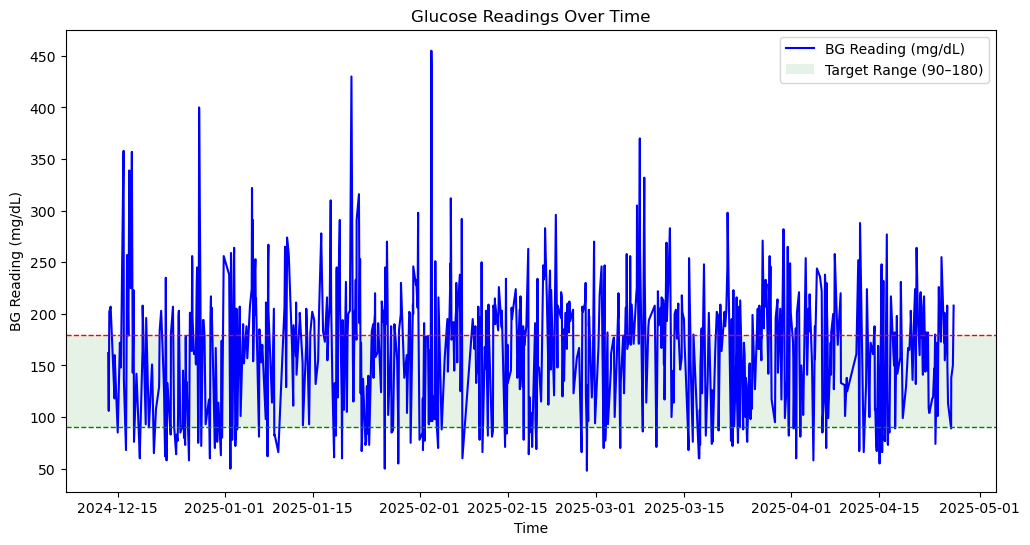

In [76]:
# Visualizing the dataset
bg = df_clean["BG Reading (mg/dL)"].dropna()

# Calculate stats
total_points = len(bg)
time_in_range = (bg.between(90, 180).sum() / total_points) * 100
hypo = (bg < 70).sum() / total_points * 100
hyper = (bg > 200).sum() / total_points * 100

# Summary table
summary = pd.DataFrame({
    "Metric": ["Time in Range (90–180)", "Hypoglycemia (<70)", "Hyperglycemia (>200)"],
    "Percentage": [time_in_range, hypo, hyper]
})

print("Readings Statistics:")
print(summary)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(bg.index, bg.values, label='BG Reading (mg/dL)', color='blue')

# Add shaded desired range
plt.axhspan(90, 180, facecolor='green', alpha=0.1, label="Target Range (90–180)")

# Add boundaries
plt.axhline(90, color='green', linestyle='--', linewidth=1)
plt.axhline(180, color='red', linestyle='--', linewidth=1)

plt.title('Glucose Readings Over Time')
plt.xlabel('Time')
plt.ylabel('BG Reading (mg/dL)')
plt.legend()
plt.show()
pdf.savefig(plt.gcf(), dpi=300, bbox_inches="tight")

### Visualising temporal patterns

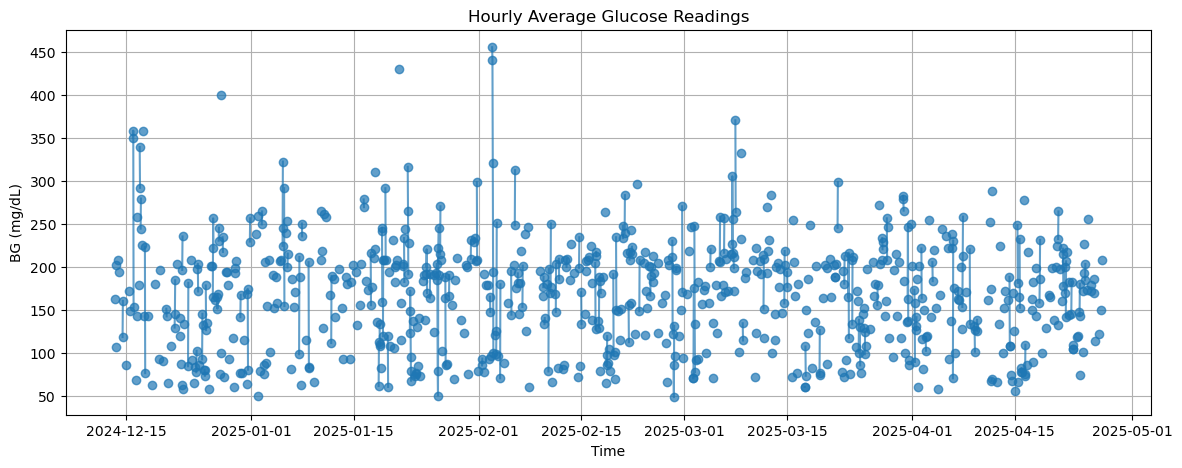

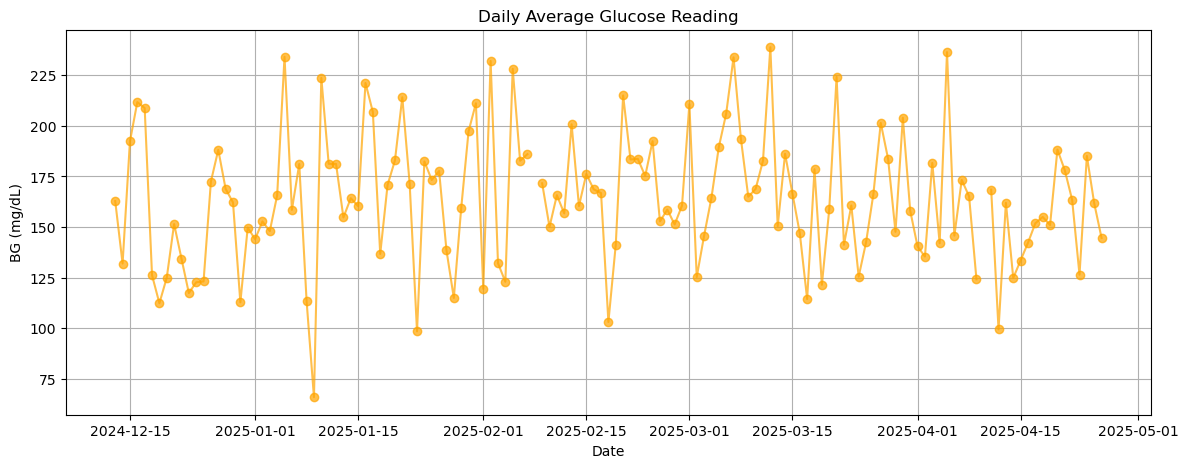

In [51]:
# Resample hourly
hourly_avg = df["BG Reading (mg/dL)"].resample("H").mean()

# Resample daily for broader trend
daily_avg = df["BG Reading (mg/dL)"].resample("D").mean()

#  Resample weekly for broader trend
weekly_avg = df["BG Reading (mg/dL)"].resample("W").mean()

# Plot hourly trend
plt.figure(figsize=(14,5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linestyle='-', alpha=0.7)
plt.title("Hourly Average Glucose Readings")
plt.xlabel("Time")
plt.ylabel("BG (mg/dL)")
plt.grid(True)
plt.show()

#Plot daily trend
plt.figure(figsize=(14,5))
plt.plot(daily_avg.index, daily_avg.values, marker='o', linestyle='-', color='orange', alpha=0.7)
plt.title("Daily Average Glucose Reading")
plt.xlabel("Date")
plt.ylabel("BG (mg/dL)")
plt.grid(True)
plt.show()


Highest average BG is at 4:00 → 257.0 mg/dL
Lowest average BG is at 14:00 → 141.2 mg/dL


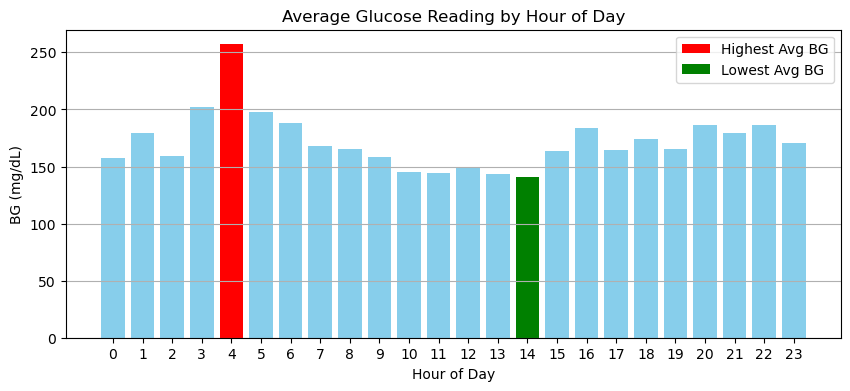

In [52]:
# Group by hours
df["hour"] = df.index.hour
hourly_pattern = df.groupby("hour")["BG Reading (mg/dL)"].mean()

# Find highest and lowest average hour
highest_hour = hourly_pattern.idxmax()
lowest_hour = hourly_pattern.idxmin()

print(f"Highest average BG is at {highest_hour}:00 → {hourly_pattern[highest_hour]:.1f} mg/dL")
print(f"Lowest average BG is at {lowest_hour}:00 → {hourly_pattern[lowest_hour]:.1f} mg/dL")

# Visualization
plt.figure(figsize=(10,4))
plt.bar(hourly_pattern.index, hourly_pattern.values, color='skyblue')

# Highlight highest and lowest bars
plt.bar(highest_hour, hourly_pattern[highest_hour], color='red', label='Highest Avg BG')
plt.bar(lowest_hour, hourly_pattern[lowest_hour], color='green', label='Lowest Avg BG')

plt.title("Average Glucose Reading by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("BG (mg/dL)")
plt.xticks(range(0,24))
plt.grid(axis='y')
plt.legend()
plt.show()


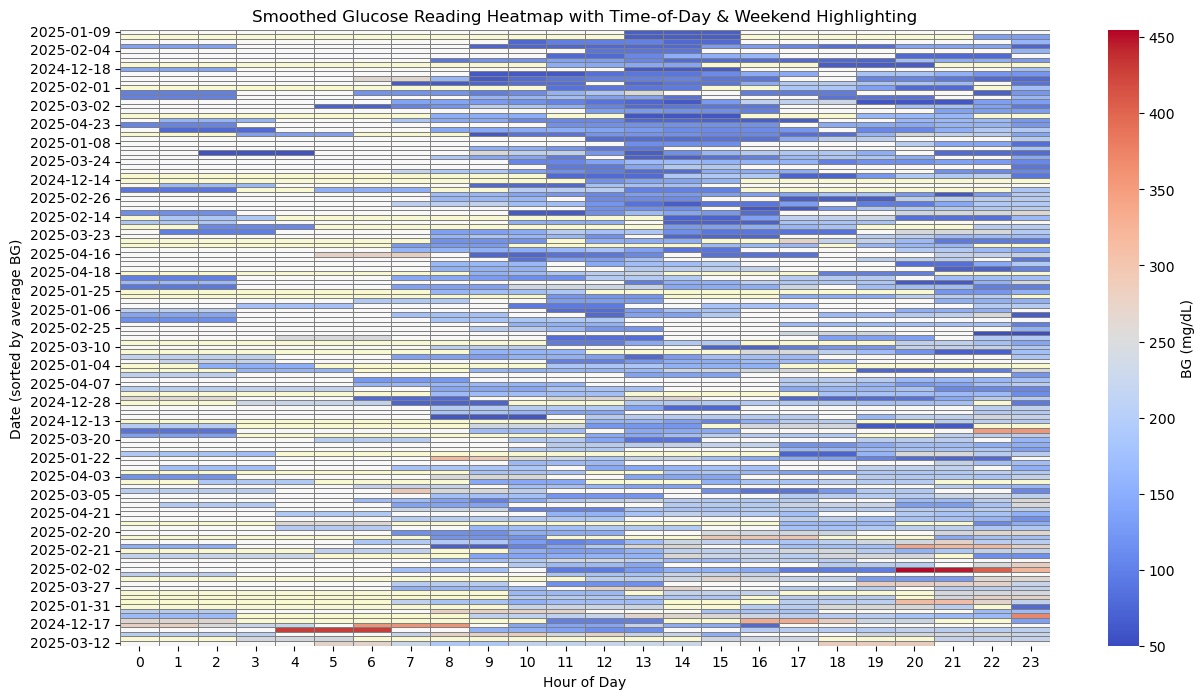

In [53]:
# Extract date and hour
df["date"] = df.index.date
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday  # Monday=0, Sunday=6

# Pivot table: rows = date, columns = hour, values = mean BG
heatmap_data = df.pivot_table(
    index="date",
    columns="hour",
    values="BG Reading (mg/dL)",
    aggfunc="mean"
)

# Smooth hourly fluctuations
heatmap_smoothed = heatmap_data.rolling(window=3, axis=1, min_periods=1).mean()

# Sort days by average BG
day_order = heatmap_smoothed.mean(axis=1).sort_values().index
heatmap_smoothed = heatmap_smoothed.loc[day_order]

# Plot heatmap
plt.figure(figsize=(15,8))
ax = sns.heatmap(
    heatmap_smoothed,
    cmap="coolwarm",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "BG (mg/dL)"}
)
plt.title("Smoothed Glucose Reading Heatmap with Time-of-Day & Weekend Highlighting")
plt.xlabel("Hour of Day")
plt.ylabel("Date (sorted by average BG)")

# Shaded vertical bands for periods of the day
periods = {
    "Night": (0, 6),
    "Morning": (6, 10),
    "Afternoon": (10, 16),
    "Evening": (16, 22),
    "Late Night": (22, 24)
}

for start_hour, end_hour in periods.values():
    ax.axvspan(start_hour, end_hour, color='gray', alpha=0.05)

# Highlight weekends with horizontal bands
for i, date in enumerate(heatmap_smoothed.index):
    weekday = pd.to_datetime(date).weekday()
    if weekday in [4,5]:  # Friday=4, Saturday=5
        ax.add_patch(plt.Rectangle(
            (0, i),  # x, y position
            heatmap_smoothed.shape[1],  # width = number of hours
            1,  # height = 1 row
            color='yellow', 
            alpha=0.15,
            zorder=-1
        ))

plt.show()


### Weekly seasonality (weekday effect)

Highest average BG is on Thu → 183.2 mg/dL
Lowest average BG is on Tue → 152.5 mg/dL


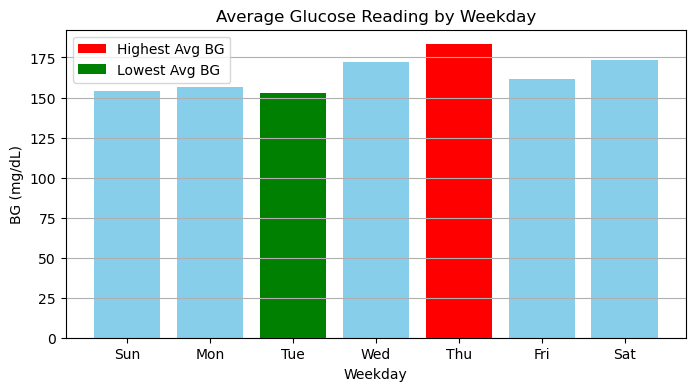

In [59]:
# Group by weekday (Monday=0, Sunday=6)
weekday_pattern = df.groupby(df.index.weekday)["BG Reading (mg/dL)"].mean()

# Map weekday numbers to labels
weekday_labels = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
labels = [weekday_labels[int(i)] for i in weekday_pattern.index]

# Find highest and lowest weekday
highest_day = weekday_pattern.idxmax()
lowest_day = weekday_pattern.idxmin()

print(f"Highest average BG is on {weekday_labels[highest_day]} → {weekday_pattern[highest_day]:.1f} mg/dL")
print(f"Lowest average BG is on {weekday_labels[lowest_day]} → {weekday_pattern[lowest_day]:.1f} mg/dL")

# Plot
plt.figure(figsize=(8,4))
plt.bar(range(len(weekday_pattern)), weekday_pattern.values, color='skyblue')

# Highlight highest and lowest
plt.bar(highest_day, weekday_pattern[highest_day], color='red', label="Highest Avg BG")
plt.bar(lowest_day, weekday_pattern[lowest_day], color='green', label="Lowest Avg BG")

plt.title("Average Glucose Reading by Weekday")
plt.xlabel("Weekday")
plt.ylabel("BG (mg/dL)")
plt.xticks(range(len(weekday_pattern)), labels)
plt.grid(axis='y')
plt.legend()
plt.show()

### Testing the trend of glucose level

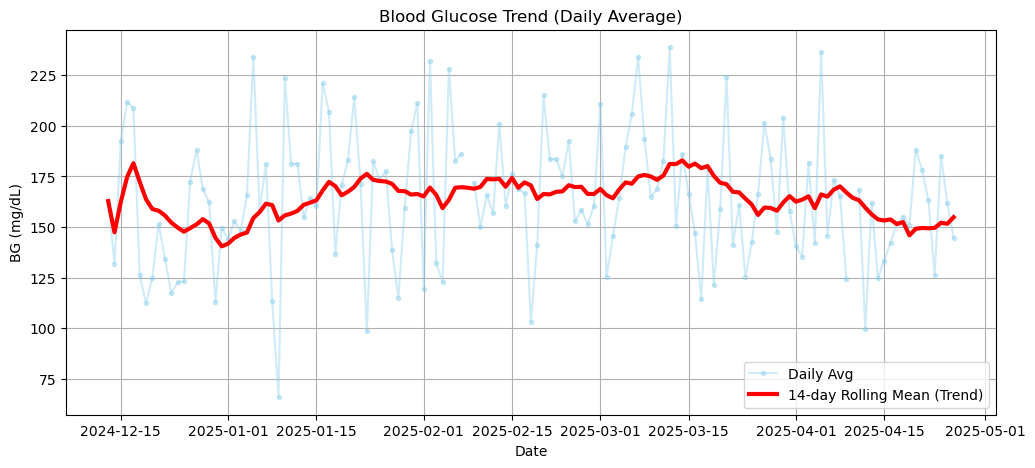

In [62]:
daily_avg = df["BG Reading (mg/dL)"].resample("D").mean()
trend = daily_avg.rolling(window=14, min_periods=1).mean()  # 2-week rolling average
plt.figure(figsize=(12,5))
plt.plot(daily_avg.index, daily_avg, marker=".", alpha=0.4, label="Daily Avg", color="skyblue")
plt.plot(trend.index, trend, linewidth=3, color="red", label="14-day Rolling Mean (Trend)")
plt.title("Blood Glucose Trend (Daily Average)")
plt.xlabel("Date")
plt.ylabel("BG (mg/dL)")
plt.legend()
plt.grid(True)
plt.show()


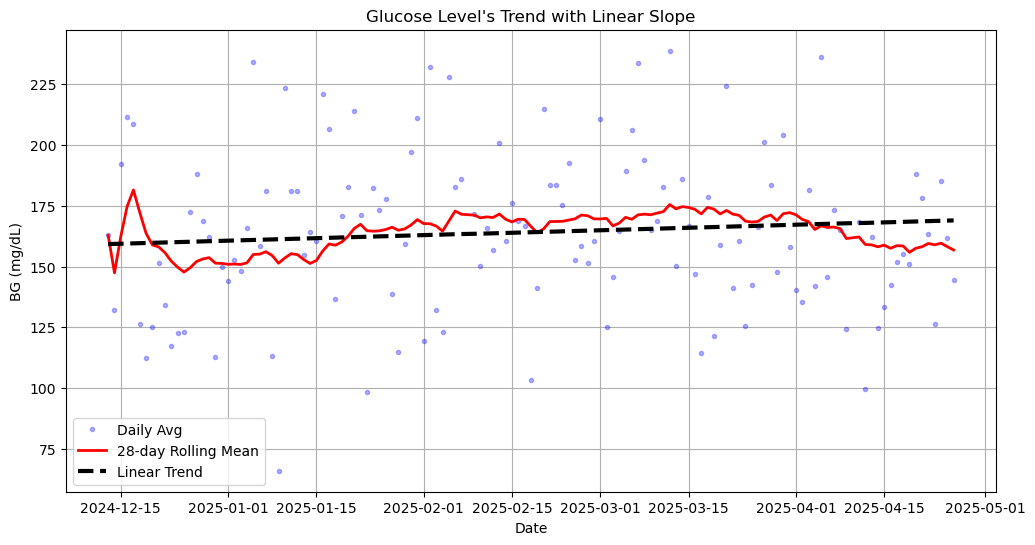

Trend slope: 0.074 mg/dL per day
Glucose level is increasing over time.


In [58]:
import statsmodels.api as sm

# Daily averages
daily_avg = df["BG Reading (mg/dL)"].resample("D").mean().dropna()

# Use a smoother (e.g. 28-day rolling mean)
smooth = daily_avg.rolling(window=28, min_periods=1).mean()

# Prepare data for regression
x = np.arange(len(smooth))  # days since start
y = smooth.values

X = sm.add_constant(x)  # add intercept
model = sm.OLS(y, X).fit()
slope = model.params[1]

# Predicted trend line
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_avg.index, daily_avg, ".", alpha=0.3, label="Daily Avg", color="blue")
plt.plot(smooth.index, smooth, linewidth=2, color="red", label="28-day Rolling Mean")
plt.plot(smooth.index, y_pred, linewidth=3, color="black", linestyle="--", label="Linear Trend")

plt.title("Glucose Level's Trend with Linear Slope")
plt.xlabel("Date")
plt.ylabel("BG (mg/dL)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Trend slope: {slope:.3f} mg/dL per day")

if slope > 0:
    print("Glucose level is increasing over time.")
elif slope < 0:
    print("Glucose level is decreasing over time.")
else:
    print("No clear long-term trend.")


## Is glucose level steady in the nights?

In [130]:
# Make sure column is numeric
df["bg"] = pd.to_numeric(df["BG Reading (mg/dL)"], errors="coerce")

# Now redo the simple overnight analysis
overnight = df.between_time("00:00", "06:00").copy()
overnight["date"] = overnight.index.date

# Drop nights without at least 2 valid BG points
night_drift = overnight.groupby("date")["bg"].apply(
    lambda x: x.dropna().iloc[-1] - x.dropna().iloc[0] if x.dropna().shape[0] >= 2 else np.nan
).dropna()

print("Median overnight BG drift:", night_drift.median(), "mg/dL")
print("Nights with upward drift (>20):", (night_drift > 20).mean()*100, "%")
print("Nights with downward drift (<-20):", (night_drift < -20).mean()*100, "%")


Median overnight BG drift: 0.0 mg/dL
Nights with upward drift (>20): 7.6923076923076925 %
Nights with downward drift (<-20): 11.538461538461538 %


### Alerts

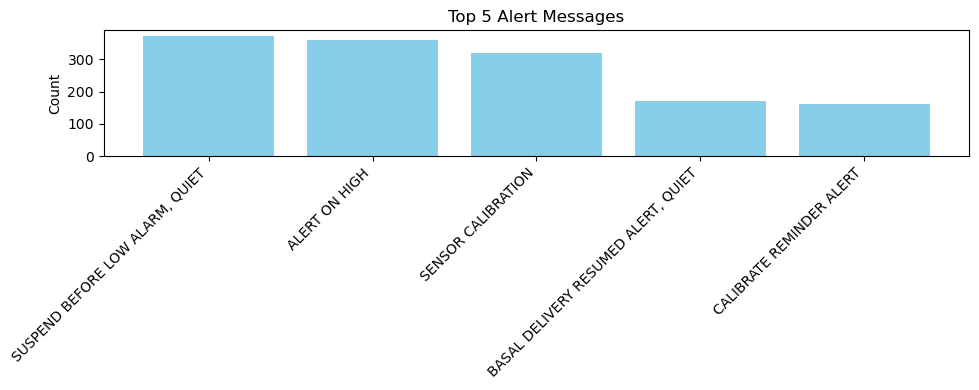

In [154]:
# Keep only rows with alerts
alerts = df.dropna(subset=['Alert']).copy()
alerts['weekday'] = alerts.index.weekday  # Mon=0, Sun=6
alerts['hour'] = alerts.index.hour
top_alerts = alerts['Alert'].value_counts().head(5)

plt.figure(figsize=(10,4))
plt.bar(top_alerts.index.astype(str), top_alerts.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Count")
plt.title("Top 5 Alert Messages")
plt.tight_layout()
plt.show()

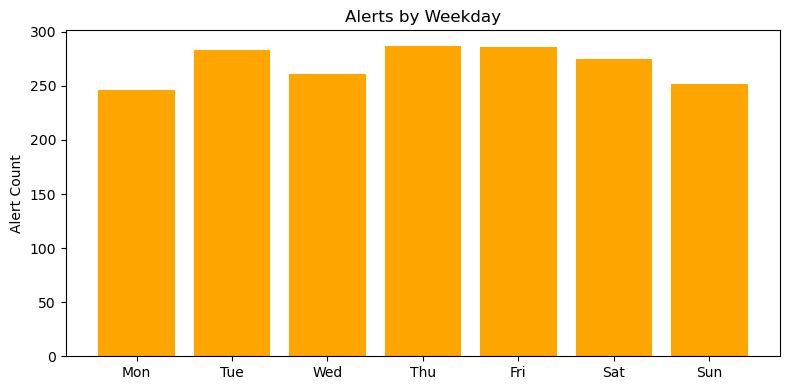

In [151]:
# alerts by weekday 
weekday_counts = alerts.groupby('weekday')['Alert'].count()

plt.figure(figsize=(8,4))
plt.bar(weekday_counts.index, weekday_counts.values, color='orange')
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.ylabel("Alert Count")
plt.title("Alerts by Weekday")
plt.tight_layout()
plt.show()


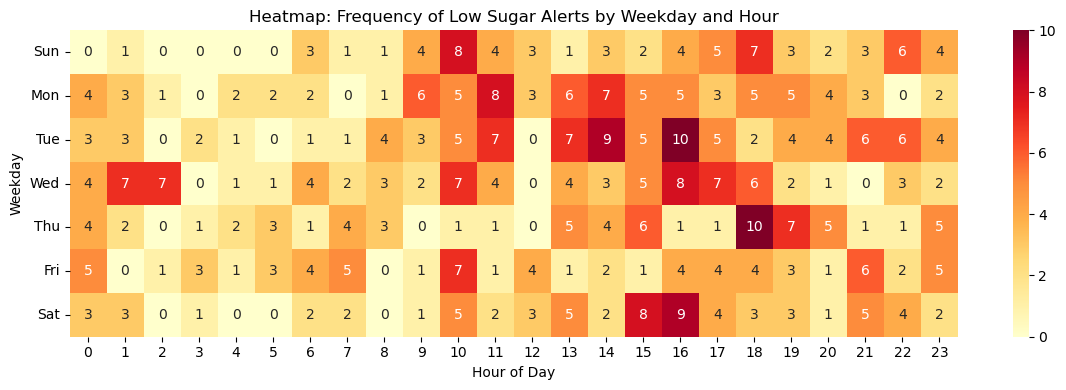

In [42]:
# Filter lOW SUGAR alerts

selected_alerts = ['SUSPEND BEFORE LOW ALARM, QUIET', 'ALERT ON LOW']

# Filter data
alerts_filtered = df.dropna(subset=['Alert']).copy()
alerts_filtered = alerts_filtered[alerts_filtered['Alert'].isin(selected_alerts)]
alerts_filtered['weekday'] = alerts_filtered.index.weekday
alerts_filtered['hour'] = alerts_filtered.index.hour

# Pivot table: rows = weekday, columns = hour, values = count
heat = alerts_filtered.pivot_table(index='weekday', columns='hour', values='Alert', aggfunc='count', fill_value=0)

# Plot
plt.figure(figsize=(12,4))
sns.heatmap(heat, cmap='YlOrRd', annot=True, fmt='d')
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.title("Heatmap: Frequency of Low Sugar Alerts by Weekday and Hour")
plt.yticks(ticks=np.arange(7)+0.5, labels=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], rotation=0)
plt.tight_layout()
plt.show()


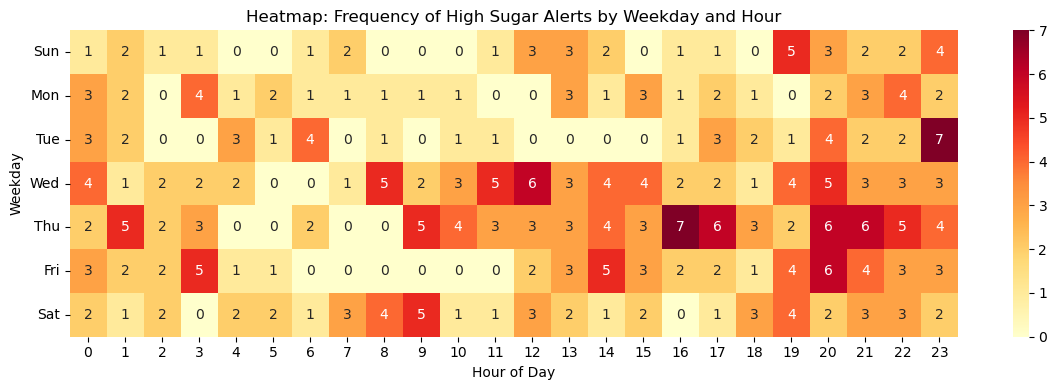

In [44]:
# Filter High SUGAR alerts

selected_alerts = ['ALERT ON HIGH']

# Filter data
alerts_filtered = df.dropna(subset=['Alert']).copy()
alerts_filtered = alerts_filtered[alerts_filtered['Alert'].isin(selected_alerts)]
alerts_filtered['weekday'] = alerts_filtered.index.weekday
alerts_filtered['hour'] = alerts_filtered.index.hour

# Pivot table: rows = weekday, columns = hour, values = count
heat = alerts_filtered.pivot_table(index='weekday', columns='hour', values='Alert', aggfunc='count', fill_value=0)

# Plot
plt.figure(figsize=(12,4))
sns.heatmap(heat, cmap='YlOrRd', annot=True, fmt='d')
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.title("Heatmap: Frequency of High Sugar Alerts by Weekday and Hour")
plt.yticks(ticks=np.arange(7)+0.5, labels=['Sun','Mon','Tue','Wed','Thu','Fri','Sat'], rotation=0)
plt.tight_layout()
plt.show()

In [46]:
# Show the time which is mostly suseptible to LOW SUGAR alerts
# Selected alerts
selected_alerts = ['SUSPEND BEFORE LOW ALARM, QUIET', 'ALERT ON LOW']

# Filter data
alerts_filtered = df.dropna(subset=['Alert']).copy()
alerts_filtered = alerts_filtered[alerts_filtered['Alert'].isin(selected_alerts)]
alerts_filtered['hour'] = alerts_filtered.index.hour
alerts_filtered['weekday'] = alerts_filtered.index.weekday  # Mon=0, Sun=6

# Mark weekend vs weekday
alerts_filtered['day_type'] = alerts_filtered['weekday'].apply(lambda x: 'Weekend' if x in [4,5] else 'Weekday')  # Friday=4, Saturday=5

# Aggregate counts per hour and day_type
hourly_counts = alerts_filtered.groupby(['day_type','hour'])['Alert'].count().reset_index()
hourly_counts = hourly_counts.rename(columns={'Alert': 'count'})

# Identify peak hour for weekday and weekend
peak_hours = hourly_counts.loc[hourly_counts.groupby('day_type')['count'].idxmax()]

print("Hourly alert counts (Weekday vs Weekend):")
print(hourly_counts.pivot(index='hour', columns='day_type', values='count').fillna(0))

print("\nPeak hour of low sugar alerts by day type:")
for _, row in peak_hours.iterrows():
    print(f"{row['day_type']}: Hour {int(row['hour'])}, Count {row['count']}")


Hourly alert counts (Weekday vs Weekend):
day_type  Weekday  Weekend
hour                      
0              14        9
1              17        2
2               8        1
3               3        4
4               4        3
5               3        6
6              12        5
7               6        9
8               9        3
9              16        1
10             30        8
11             25        2
12              9        4
13             23        6
14             24        6
15             25        7
16             36        5
17             24        5
18             23       14
19             17       10
20             12        6
21             17        7
22             19        3
23             14       10

Peak hour of low sugar alerts by day type:
Weekday: Hour 16, Count 36
Weekend: Hour 18, Count 14


In [47]:
# Show the time which is mostly suseptible to HIGH SUGAR alerts
# Selected alerts
selected_alerts = ['ALERT ON HIGH']

# Filter data
alerts_filtered = df.dropna(subset=['Alert']).copy()
alerts_filtered = alerts_filtered[alerts_filtered['Alert'].isin(selected_alerts)]
alerts_filtered['hour'] = alerts_filtered.index.hour
alerts_filtered['weekday'] = alerts_filtered.index.weekday  # Mon=0, Sun=6

# Mark weekend vs weekday
alerts_filtered['day_type'] = alerts_filtered['weekday'].apply(lambda x: 'Weekend' if x in [4,5] else 'Weekday')  # Friday=4, Saturday=5

# Aggregate counts per hour and day_type
hourly_counts = alerts_filtered.groupby(['day_type','hour'])['Alert'].count().reset_index()
hourly_counts = hourly_counts.rename(columns={'Alert': 'count'})

# Identify peak hour for weekday and weekend
peak_hours = hourly_counts.loc[hourly_counts.groupby('day_type')['count'].idxmax()]

print("Hourly alert counts (Weekday vs Weekend):")
print(hourly_counts.pivot(index='hour', columns='day_type', values='count').fillna(0))

print("\nPeak hour of high sugar alerts by day type:")
for _, row in peak_hours.iterrows():
    print(f"{row['day_type']}: Hour {int(row['hour'])}, Count {row['count']}")


Hourly alert counts (Weekday vs Weekend):
day_type  Weekday  Weekend
hour                      
0            13.0      5.0
1             8.0      7.0
2             5.0      4.0
3             7.0      8.0
4             8.0      1.0
5             5.0      1.0
6             7.0      2.0
7             7.0      0.0
8            11.0      0.0
9             8.0      5.0
10            6.0      4.0
11            8.0      3.0
12           12.0      5.0
13           11.0      6.0
14            8.0      9.0
15            9.0      6.0
16            5.0      9.0
17            9.0      8.0
18            7.0      4.0
19           14.0      6.0
20           16.0     12.0
21           13.0     10.0
22           14.0      8.0
23           18.0      7.0

Peak hour of high sugar alerts by day type:
Weekday: Hour 23, Count 18
Weekend: Hour 20, Count 12
